In [1]:
import numpy as np
import pandas as pd
import os

from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
from timm import create_model

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

In [2]:
def load_images(main_folder):
    image_data = []

    for chrom in range(0, 25):
        chrom_folder = os.path.join(main_folder, str(chrom))

        if not os.path.isdir(chrom_folder):
            continue

        # Get all TIFF files in the subfolder
        tiff_files = [f for f in os.listdir(chrom_folder) if f.lower().endswith(('.tiff', '.tif'))]

        for file in tiff_files:
            file_path = os.path.join(chrom_folder, file)
            image = Image.open(file_path)
            image_data.append((image, chrom))

    return image_data

In [3]:
import shutil

# move data to /content 4 easy access
# shutil.move(page0526_chromosome_dataset_path, '/content/data')

In [4]:
dataset_path = '/kaggle/input/chromosome-dataset/train_data/final/single_chromosome'

In [5]:
ims = load_images(dataset_path)

print(f"Loaded {len(ims)} TIFF images")

if ims:
    ims[0][0].show()
    print(f"Label of first image: {ims[0][1]}")

Loaded 25299 TIFF images
Label of first image: 1


In [6]:
from PIL.TiffImagePlugin import TiffImageFile
import random

def visualize(ims_list, num=25):
  display = min(len(ims_list), num)
  cols = int(np.ceil(np.sqrt(display)))
  rows = int((np.ceil(display / cols)))

  plt.figure(figsize=(cols * 2, rows * 2))

  if len(ims_list) > 0:
    indices = random.sample(range(len(ims_list)), display)

  for i, idx in enumerate(indices):
    plt.subplot(rows, cols, i + 1)
    im, label = ims_list[idx]

    # if tensor, convert to numpy
    if hasattr(im, 'detach'):
      im = im.detach().cpu().numpy()
    if isinstance(im, TiffImageFile):
      im = np.array(im)

    # (C, H, W) to (H, W, C)
    if im.shape == 3 and im.shape[0] in [1, 3]:
      im=np.transpose(im, (1, 2, 0))

    # normalize
    if im.max() > 1.0:
      im = im/255.0

    plt.imshow(im, cmap='gray')
    plt.title(str(label))
    plt.axis('off')

  plt.tight_layout()
  plt.show()


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmph_19vf7c.PNG'


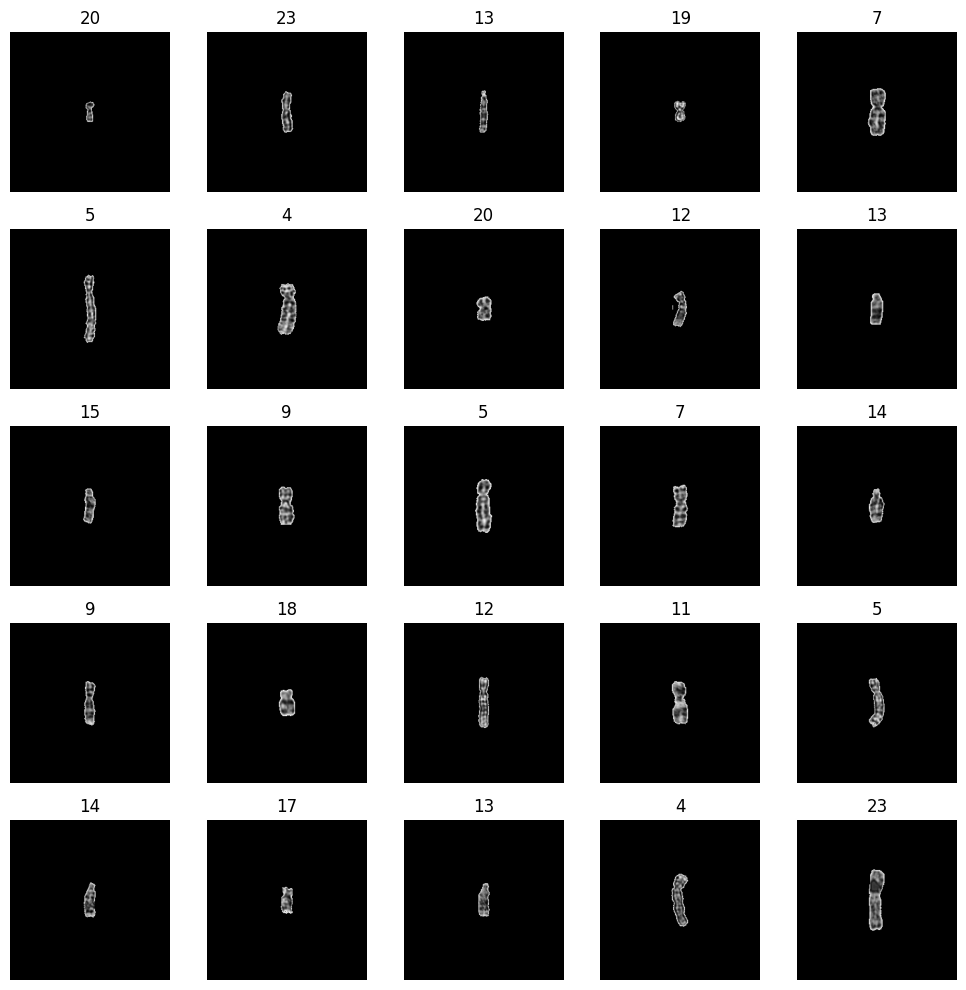

In [7]:
visualize(ims)

In [8]:
class ChromosomeDataset(Dataset):
    def __init__(self, folder, ims_list=None, transform=None):
        self.image_data = load_images(folder) if ims_list is None else ims_list
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        im, label = self.image_data[idx]

        if self.transform:
            im = self.transform(im)
        return im, label - 1

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
EPOCHS = 25
WORKERS = 2
train_path = '/kaggle/input/chromosome-dataset/train_data/final/single_chromosome'
test_path = '/kaggle/input/chromosome-dataset/test_data/single_chromosome'
CLASSES = 24
wandb_log = True
project_name = 'chromosome-classification'
tags=['resnet50']
project_config={
            "epochs": EPOCHS,
        }
val_split = 0.2
CHANNEL = 1
model_name = 'resnet50'

In [10]:
import torch
import torch.nn as  nn
import torch.nn.functional as F

# follow: https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [11]:
from torch.utils.data import random_split

transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # EfficientNet normalization
])

fullset = ChromosomeDataset(train_path, ims, transform=transform)
testset = ChromosomeDataset(test_path, transform=transform)

train_len = int(len(fullset) * (1 - val_split))
val_len = len(fullset) - train_len

generator = torch.Generator().manual_seed(42)
trainset, valset = random_split(fullset, [train_len, val_len], generator=generator)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [12]:
# check label
# all_train_labels = [label for _, label in trainset]
# unique_train_classes = sorted(set(all_train_labels))
# print("Unique classes in training set:", unique_train_classes)

In [13]:
im, labels = next(iter(trainloader))
print(f"Batch image shape: {im.shape}, Batch labels: {labels}")
len(trainset), len(valset), len(testset)

Batch image shape: torch.Size([32, 1, 224, 224]), Batch labels: tensor([ 0,  4, 21, 11, 16,  5, 11,  5, 23, 10, 21,  6, 18, 11, 12, 14,  0, 19,
         8,  2, 19, 14,  2,  4, 22, 18,  6,  9,  2, 14, 10,  4])


(20239, 5060, 2801)

In [14]:
from torchvision import models

if model_name == 'resnet50-pretrained':
    model = models.resnet50(pretrained=True)
elif model_name == 'efficientnet':
    model = create_model('efficientnet_b1', pretrained=True)
else:
    model = ResNet50(CLASSES, CHANNEL)

In [15]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: page0526 (iai-uet-vnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [16]:
from torchmetrics import Accuracy, F1Score, Precision, Recall, MeanMetric
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

def training_step(model, dataloader, loss_func, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch") as pbar:
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            pbar.set_postfix(loss=loss.item())

            

    avg_train_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    if wandb.run is not None:
        wandb.log({
            "train/loss": avg_train_loss,
            "train/acc": accuracy,
            "epoch": epoch
        })
    return avg_train_loss, accuracy

def evaluation_step(model, dataloader, loss_func, epoch):
    model.eval()
    val_loss = 0.0
    acc_metric = MulticlassAccuracy(num_classes=CLASSES, average='macro').to(device)
    pre_metric = MulticlassPrecision(num_classes=CLASSES, average='macro').to(device)
    rec_metric = MulticlassRecall(num_classes=CLASSES, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=CLASSES, average='macro').to(device)
    images = []
    
    with torch.no_grad(), tqdm(dataloader, total=len(dataloader), desc="Validation", unit="batch") as pbar:
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_func(output, target).item()
            preds = torch.argmax(output, dim=1)
            
            acc_metric.update(preds, target)
            pre_metric.update(preds, target)
            rec_metric.update(preds, target)
            f1_metric.update(preds, target)

            pbar.set_postfix(val_loss=val_loss / (batch_idx + 1))

            if batch_idx == 0 and wandb.run is not None:
                for im, pred, label in zip(data[:8], preds[:8], target[:8]):
                    im = im.cpu()
                    caption = f"Pred: {pred + 1} | Label: {label + 1}"
                    images.append(wandb.Image(im, caption=caption))
            

    avg_val_loss = val_loss / len(dataloader)
    accuracy = acc_metric.compute().item() * 100
    precision = pre_metric.compute().item()
    recall = rec_metric.compute().item()
    f1 = f1_metric.compute().item()
    if wandb.run is not None:
        wandb.log({
            "val/loss": avg_val_loss,
            "val/acc": accuracy,
            "epoch": epoch,
            "val/precision": precision,
            "val/recall": recall,
            "val/f1": f1,
            "val/images": images
        })
    return avg_val_loss, accuracy
    
def test_step(model, dataloader, loss_func):
    model.eval()

    acc_metric = MulticlassAccuracy(num_classes=CLASSES, average='macro').to(device)
    pre_metric = MulticlassPrecision(num_classes=CLASSES, average='macro').to(device)
    rec_metric = MulticlassRecall(num_classes=CLASSES, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=CLASSES, average='macro').to(device)
    loss_metric = MeanMetric().to(device)
    images = []
    
    with torch.no_grad(), tqdm(dataloader, desc='Testing', unit='batch') as pbar:
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = loss_func(output, target)
            preds = torch.argmax(output, dim=1)

            acc_metric.update(preds, target)
            pre_metric.update(preds, target)
            rec_metric.update(preds, target)
            f1_metric.update(preds, target)
            loss_metric.update(loss)

            pbar.set_postfix(loss=loss.item())

            if batch_idx == 0 and wandb.run is not None:
                for im, pred, label in zip(data[:8], preds[:8], target[:8]):
                    im = im.cpu()
                    caption = f"Pred: {pred + 1} | Label: {label + 1}"
                    images.append(wandb.Image(im, caption=caption))

    avg_loss = loss_metric.compute().item()
    accuracy = acc_metric.compute().item() * 100
    precision = pre_metric.compute().item()
    recall = rec_metric.compute().item()
    f1 = f1_metric.compute().item()

    if wandb.run is not None:
        wandb.log({
            "test/loss": avg_loss,
            "test/acc": accuracy,
            "test/precision": precision,
            "test/recall": recall,
            "test/f1": f1,
            "test/images": images
        })

    print(f"\nTest Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
    return avg_loss, accuracy, precision, recall, f1

In [17]:
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

    
train_losses = []
val_losses = []
train_acc = []
val_acc = []

if wandb_log:
    import time
    current_time = time.strftime("%Y-%m-%d_%H-%M-%S")
    
    wandb_logger = wandb.init(
        project=project_name,
        name=f"{current_time}",
        tags=tags,
        config=project_config
    )

for epoch in range(EPOCHS):
    avg_train_loss, avg_train_acc = training_step(model, trainloader, loss_func, optimizer, epoch)
    avg_val_loss, avg_val_acc = evaluation_step(model, valloader, loss_func, epoch)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_acc.append(avg_train_acc)
    val_acc.append(avg_val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {avg_train_acc:.2f}%, Validation Accuracy: {avg_val_acc:.2f}%")

avg_loss, accuracy, precision, recall, f1 = test_step(model, testloader, loss_func)

if wandb.run is not None:
    wandb.save("final_model.pth")
    wandb.finish()
    
print('Training complete!')
torch.save(model.state_dict(), "model.pth")

Validation: 100%|██████████| 159/159 [00:10<00:00, 14.57batch/s, val_loss=2.26]


Epoch [1/25], Training Loss: 2.1181, Validation Loss: 2.2630, Training Accuracy: 24.06%, Validation Accuracy: 24.39%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.82batch/s, val_loss=0.777]


Epoch [2/25], Training Loss: 0.9758, Validation Loss: 0.7768, Training Accuracy: 67.54%, Validation Accuracy: 74.86%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.83batch/s, val_loss=0.395]


Epoch [3/25], Training Loss: 0.4980, Validation Loss: 0.3947, Training Accuracy: 84.44%, Validation Accuracy: 88.35%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.85batch/s, val_loss=0.347]


Epoch [4/25], Training Loss: 0.3382, Validation Loss: 0.3474, Training Accuracy: 89.48%, Validation Accuracy: 88.85%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.86batch/s, val_loss=0.31] 


Epoch [5/25], Training Loss: 0.2777, Validation Loss: 0.3100, Training Accuracy: 91.52%, Validation Accuracy: 90.53%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.90batch/s, val_loss=0.276]


Epoch [6/25], Training Loss: 0.2361, Validation Loss: 0.2757, Training Accuracy: 92.54%, Validation Accuracy: 91.45%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.86batch/s, val_loss=0.333]


Epoch [7/25], Training Loss: 0.2157, Validation Loss: 0.3325, Training Accuracy: 93.01%, Validation Accuracy: 90.38%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.77batch/s, val_loss=0.276]


Epoch [8/25], Training Loss: 0.1830, Validation Loss: 0.2764, Training Accuracy: 94.36%, Validation Accuracy: 91.51%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.77batch/s, val_loss=0.333]


Epoch [9/25], Training Loss: 0.1647, Validation Loss: 0.3332, Training Accuracy: 94.67%, Validation Accuracy: 90.48%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.76batch/s, val_loss=0.28] 


Epoch [10/25], Training Loss: 0.1580, Validation Loss: 0.2797, Training Accuracy: 94.92%, Validation Accuracy: 91.48%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.74batch/s, val_loss=0.275]


Epoch [11/25], Training Loss: 0.1322, Validation Loss: 0.2755, Training Accuracy: 95.82%, Validation Accuracy: 92.15%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.79batch/s, val_loss=0.299]


Epoch [12/25], Training Loss: 0.1286, Validation Loss: 0.2985, Training Accuracy: 95.95%, Validation Accuracy: 90.09%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.70batch/s, val_loss=0.281]


Epoch [13/25], Training Loss: 0.1065, Validation Loss: 0.2811, Training Accuracy: 96.63%, Validation Accuracy: 91.67%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.73batch/s, val_loss=0.287]


Epoch [14/25], Training Loss: 0.0968, Validation Loss: 0.2870, Training Accuracy: 96.91%, Validation Accuracy: 91.18%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.78batch/s, val_loss=0.241]


Epoch [15/25], Training Loss: 0.0936, Validation Loss: 0.2414, Training Accuracy: 96.99%, Validation Accuracy: 93.05%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.77batch/s, val_loss=0.257]


Epoch [16/25], Training Loss: 0.0808, Validation Loss: 0.2575, Training Accuracy: 97.44%, Validation Accuracy: 92.62%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.80batch/s, val_loss=0.272]


Epoch [17/25], Training Loss: 0.0700, Validation Loss: 0.2725, Training Accuracy: 97.71%, Validation Accuracy: 92.78%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.77batch/s, val_loss=0.257]


Epoch [18/25], Training Loss: 0.0709, Validation Loss: 0.2568, Training Accuracy: 97.73%, Validation Accuracy: 93.60%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.83batch/s, val_loss=0.21] 


Epoch [19/25], Training Loss: 0.0690, Validation Loss: 0.2098, Training Accuracy: 97.67%, Validation Accuracy: 94.67%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.90batch/s, val_loss=0.336]


Epoch [20/25], Training Loss: 0.0511, Validation Loss: 0.3357, Training Accuracy: 98.39%, Validation Accuracy: 91.82%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.89batch/s, val_loss=0.25] 


Epoch [21/25], Training Loss: 0.0501, Validation Loss: 0.2497, Training Accuracy: 98.29%, Validation Accuracy: 93.74%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.81batch/s, val_loss=0.281]


Epoch [22/25], Training Loss: 0.0538, Validation Loss: 0.2812, Training Accuracy: 98.33%, Validation Accuracy: 92.54%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.90batch/s, val_loss=0.25] 


Epoch [23/25], Training Loss: 0.0428, Validation Loss: 0.2497, Training Accuracy: 98.52%, Validation Accuracy: 94.04%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.86batch/s, val_loss=0.242]


Epoch [24/25], Training Loss: 0.0445, Validation Loss: 0.2417, Training Accuracy: 98.58%, Validation Accuracy: 93.79%


Validation: 100%|██████████| 159/159 [00:10<00:00, 14.81batch/s, val_loss=0.283]


Epoch [25/25], Training Loss: 0.0404, Validation Loss: 0.2830, Training Accuracy: 98.65%, Validation Accuracy: 93.79%


Testing: 100%|██████████| 88/88 [00:06<00:00, 14.24batch/s, loss=0.48]   



Test Loss: 0.3801 | Accuracy: 92.17%
Precision: 0.9187 | Recall: 0.9217 | F1 Score: 0.9184


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
test/acc,▁
test/f1,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc,▁▅▇▇▇▇▇██████████████████
train/loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▆▇▇█████████████████████
val/f1,▁▆▇▇█████████████████████
val/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training complete!


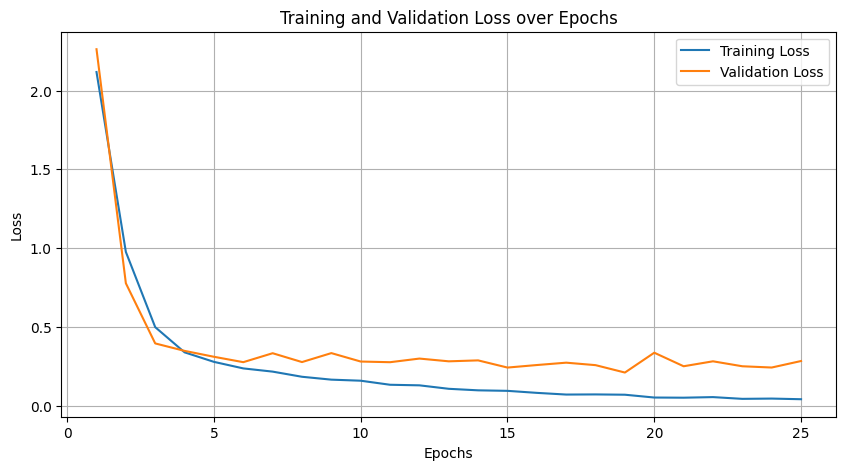

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

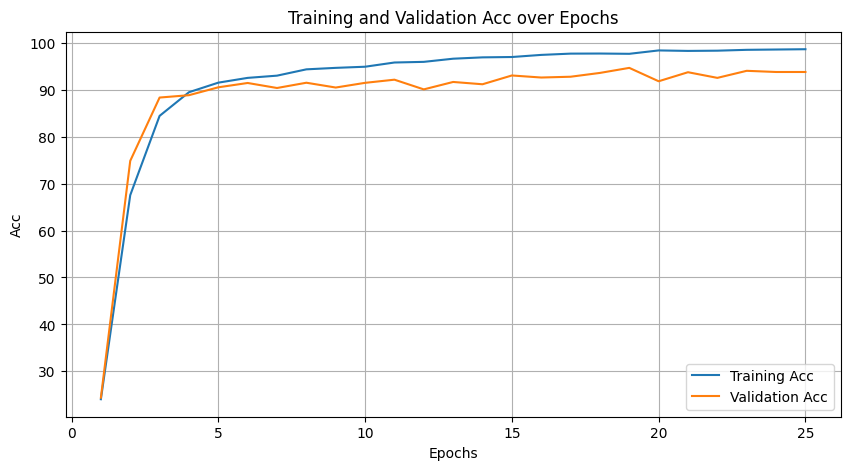

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_acc, label='Training Acc')
plt.plot(range(1, EPOCHS + 1), val_acc, label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title('Training and Validation Acc over Epochs')
plt.legend()
plt.grid(True)
plt.show()